<a href="https://colab.research.google.com/github/AngelTroncoso/s-20-10-data/blob/Melisa/Copia_An%C3%A1lisis_METS_OPS_Melisa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [110]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
import os
os.chdir('/content/drive/MyDrive')

In [112]:
!ls

'Activity Exemplar: Course 5 Automatidata Executive Summary.gslides'
'Activity Template: RACI Matrix.gdoc'
 base-de-datos-mets-opt.csv
 Biología
 Classroom
'Colab Notebooks'
'Contenido Pen'
'Copia de Official TimelineJS3 Template'$'\n'' (1).gsheet'
'Copia de Official TimelineJS3 Template'$'\n''.gsheet'
'Desayuno: Infusión con leche.gdoc'
 DNI_Elena.tif
 DNI_meli.pdf
'Learner-facing C3 Automatidata dataset for Tableau project (1).gsheet'
'Learner-facing C3 Automatidata dataset for Tableau project.gsheet'
 Libros
 LibroTambienSoyItaliano_3eraEdicion.gdoc
 meli.rar
'Protocolo DAFNA 21.05.18.docx'


In [113]:
# Cargar dataset
df = pd.read_csv('/content/drive/MyDrive/base-de-datos-mets-opt.csv', encoding='latin-1')


In [114]:
# Vista previa de las dimensiones de dataaset e identificar inconsistencias
print('Forma:', df.shape)
print('\
Columas:', df.columns.tolist())
print('\
Valores nulos:')
print(df.isnull().sum())
print('\
duplicados:', df.duplicates().sum() if hasattr(df, 'duplicates') else len(df[df.duplicated()]))
print('\
Muestra de los datos:')
print(df.head())

Forma: (466, 18)
Columas: ['EXPEDIENTE', 'NOMBRE', 'EDAD', 'SEXO', 'TUMOR PRIMARIO', 'SUBTIPO HISTOLOGICO', 'PERFIL MOLECULAR', 'TAMAÑO (mm)', 'LOCALIZACIÓN', 'CIRUGIA PREVIA', 'SRS', 'DOSIS (Gy)', 'TECNICA ', 'TRATAMIENTO SISTEMICO', 'RESPUESTA (CRITERIOS RANO)', '1ER ESTUDIO DE SEGUIMIENTO', 'RC', 'RADIONECROSIS']
Valores nulos:
EXPEDIENTE                    244
NOMBRE                        244
EDAD                            1
SEXO                            1
TUMOR PRIMARIO                  1
SUBTIPO HISTOLOGICO            20
PERFIL MOLECULAR              176
TAMAÑO (mm)                     1
LOCALIZACIÓN                    0
CIRUGIA PREVIA                  0
SRS                             1
DOSIS (Gy)                      0
TECNICA                         0
TRATAMIENTO SISTEMICO          70
RESPUESTA (CRITERIOS RANO)      0
1ER ESTUDIO DE SEGUIMIENTO    336
RC                            121
RADIONECROSIS                   0
dtype: int64
duplicados: 8
Muestra de los datos:
   EXP

Se muestra una cantidad significativa de valores nulos en varias columnas (EXPEDIENTE, NOMBRE, PERFIL MOLECULAR, TRATAMIENTO SISTEMICO, 1ER ESTUDIO DE SEGUIMIENTO y RC) y 8 filas duplicadas.

Primero, para un próximo análisis de tipo A/B testing, nos aseguraremos de que cada valor de la comlumna "EXPEDIENTE" sea único, asignándole un único ID.

In [115]:
# Asegurarse de que los IDs en la columna 'EXPEDIENTE' sean únicos
# Si existen duplicados, añadir un sufijo para hacerlos únicos
df['EXPEDIENTE'] = df['EXPEDIENTE'].astype(str)  # Convertir a string para su manipulación
df['EXPEDIENTE'] = df.groupby('EXPEDIENTE').cumcount().astype(str) + '_' + df['EXPEDIENTE']

# Verificar cambios
print('Updated EXPEDIENTE column with unique IDs:')
print(df['EXPEDIENTE'].head())

Updated EXPEDIENTE column with unique IDs:
0    0_209406.0
1    0_225523.0
2    1_225523.0
3    2_225523.0
4    3_225523.0
Name: EXPEDIENTE, dtype: object


In [116]:
# Manejo de datos duplicados eliminándolos
df_cleaned = df.drop(['NOMBRE', '1ER ESTUDIO DE SEGUIMIENTO', 'RC', 'RADIONECROSIS'], axis=1) # Pass column names as a list
df_cleaned = df_cleaned.drop_duplicates()

# Rellene los valores nulos de las columnas numéricas con su mediana y las columnas categóricas con 'Desconocido'
for col in df_cleaned.columns:
    if df_cleaned[col].dtype in ['float64', 'int64']:
        df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)
    else:
        df_cleaned[col].fillna('Unknown', inplace=True)

# Verificar la limpieza de los datos
print("Forma después de la limpieza:", df_cleaned.shape)
print("\
Valores nulos después de la limpieza:")
print(df_cleaned.isnull().sum())
print("\
Muestra de los datos después de la limpieza:")
print(df_cleaned.head())

Forma después de la limpieza: (466, 14)
Valores nulos después de la limpieza:
EXPEDIENTE                    0
EDAD                          0
SEXO                          0
TUMOR PRIMARIO                0
SUBTIPO HISTOLOGICO           0
PERFIL MOLECULAR              0
TAMAÑO (mm)                   0
LOCALIZACIÓN                  0
CIRUGIA PREVIA                0
SRS                           0
DOSIS (Gy)                    0
TECNICA                       0
TRATAMIENTO SISTEMICO         0
RESPUESTA (CRITERIOS RANO)    0
dtype: int64
Muestra de los datos después de la limpieza:
   EXPEDIENTE  EDAD SEXO  TUMOR PRIMARIO           SUBTIPO HISTOLOGICO  \
0  0_209406.0  55.0    F  CÁNCER DE MAMA  CARCINOMA DUCTAL INFILTRANTE   
1  0_225523.0  56.0    M    CÁNCER RENAL   CARCINOMA DE CÉLULAS CLARAS   
2  1_225523.0  56.0    M    CÁNCER RENAL   CARCINOMA DE CÉLULAS CLARAS   
3  2_225523.0  56.0    M    CÁNCER RENAL   CARCINOMA DE CÉLULAS CLARAS   
4  3_225523.0  56.0    M    CÁNCER RENAL   CAR

De la columna "RESPUESTA (CRITERIOS RANO)" construir una variable binaria , es decir, si la respuesta es ESTABLE o PROGRESIÓN se asignará el valor 0 y al resto el valor 1

In [117]:
print("Valores únicos en RESPUESTA (CRITERIOS RANO):")
print(df_cleaned['RESPUESTA (CRITERIOS RANO)'].unique())

Valores únicos en RESPUESTA (CRITERIOS RANO):
['RESPUESTA COMPLETA ' 'ESTABLE' 'RESPUESTA PARCIAL' 'RESPUESTA COMPLETA'
 'PROGRESIÓN' 'ESTABLE ' 'PROGRESION']


In [118]:
df_cleaned['RESPUESTA (CRITERIOS RANO)'] = df_cleaned['RESPUESTA (CRITERIOS RANO)'].replace({
    'RESPUESTA COMPLETA ': 'RESPUESTA COMPLETA',
    'ESTABLE ': 'ESTABLE',
    'PROGRESION': 'PROGRESIÓN'
}, regex=False)

In [119]:
# Asignar a la columna 'RESPUESTA (CRITERIOS RANO)' valor binario
def map_response(value):
    if value.strip().upper() in ['ESTABLE', 'PROGRESIÓN']:
        return 0
    else:
        return 1

df_cleaned['RESPUESTA_BINARIA'] = df_cleaned['RESPUESTA (CRITERIOS RANO)'].apply(map_response)

# Verificar cambios
print('Columna RESPUESTA_BINARIA actualizada:')
print(df_cleaned[['RESPUESTA (CRITERIOS RANO)', 'RESPUESTA_BINARIA']].head())

Columna RESPUESTA_BINARIA actualizada:
  RESPUESTA (CRITERIOS RANO)  RESPUESTA_BINARIA
0         RESPUESTA COMPLETA                  1
1                    ESTABLE                  0
2          RESPUESTA PARCIAL                  1
3          RESPUESTA PARCIAL                  1
4                    ESTABLE                  0


Realizar una prueba chi-cuadrado. Analizar la relación entre “CIRUGÍA PREVIA” (variable categórica) y “RESPUESTA_BINARIA” (resultado binario) para determinar si la cirugía previa impacta significativamente en la respuesta binaria.

In [120]:
print("Valores únicos en CIRUGIA PREVIA:")
print(df['CIRUGIA PREVIA'].unique())

Valores únicos en CIRUGIA PREVIA:
['SI' 'NO' 'NO ']


In [121]:
df_cleaned['CIRUGIA PREVIA'] = df_cleaned['CIRUGIA PREVIA'].str.strip()

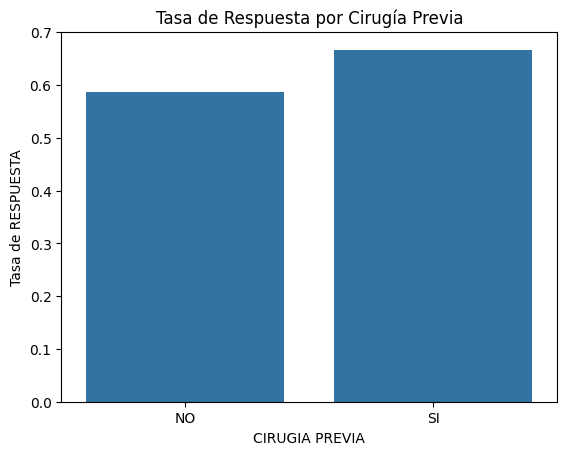

Resultado del test Chi-squared:
Chi2: 0.44244832888963564
p-value: 0.5059431123526137
Grados de libertad: 1
Frecuencias esperadas:
[[177.76824034 258.23175966]
 [ 12.23175966  17.76824034]]


In [122]:
# Agrupar datos por 'CIRUGIA PREVIA' y calcular la media de 'RESPUESTA_BINARIA'
grouped_data = df_cleaned.groupby('CIRUGIA PREVIA')['RESPUESTA_BINARIA'].mean()

# Realizar prueba de chi-cuadrado para evaluar la independencia
contingency_table = pd.crosstab(df_cleaned['CIRUGIA PREVIA'], df_cleaned['RESPUESTA_BINARIA'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Visualizar resultados
sns.barplot(x=grouped_data.index, y=grouped_data.values)
plt.title('Tasa de Respuesta por Cirugía Previa')
plt.xlabel('CIRUGIA PREVIA')
plt.ylabel('Tasa de RESPUESTA')
plt.show()

#Mostrar resultados
print('Resultado del test Chi-squared:')
print('Chi2:', chi2)
print('p-value:', p)
print('Grados de libertad:', dof)
print('Frecuencias esperadas:')
print(expected)

Se concluye a partir de los resultados de la prueba de chi-cuadrado (valor p = 0.5059> 0,05), no hay diferencia estadísticamente significativa en las tasas de respuesta entre pacientes con y sin cirugía previa. La visualización muestra proporciones de respuesta similares entre ambos grupos.

Para una siguiente prueba A/B entre “TRATAMIENTO SISTEMICO” y “RESPUESTA_BINARIA”, se analizará la relación entre estas variables mediante una prueba de chi-cuadrado. Visualizar los resultados.


Resultados del Test Chi-cuadrado:
Estadístico Chi2: 133.2487
Valor p: 0.0000

Tabla de contingencia:
RESPUESTA_BINARIA                                    0   1
TRATAMIENTO SISTEMICO                                     
5 CICLOS NO ESPECIFICA                               3   0
AFATINIB                                             4   4
ALEKTINIB                                            0   1
ALETINIB                                             3  11
BEVACIZUMAB                                          1   1
BEVACIZUMAB + PEMETREXED                             7  13
CABOZATINIB                                          0   1
CAPECITABINE                                        27   8
CAPECITABINE + FULVESTRANT                           1   2
CAPECITABINE + TRASTUZUMAB                           3  13
CAPECITABINE + TRASTUZUMAB + EXEMESTANO              0   5
CARBOPLATINO                                         1   4
CARBOPLATINO + PACLITAXEL                            3   9
CARBOPLATINO 

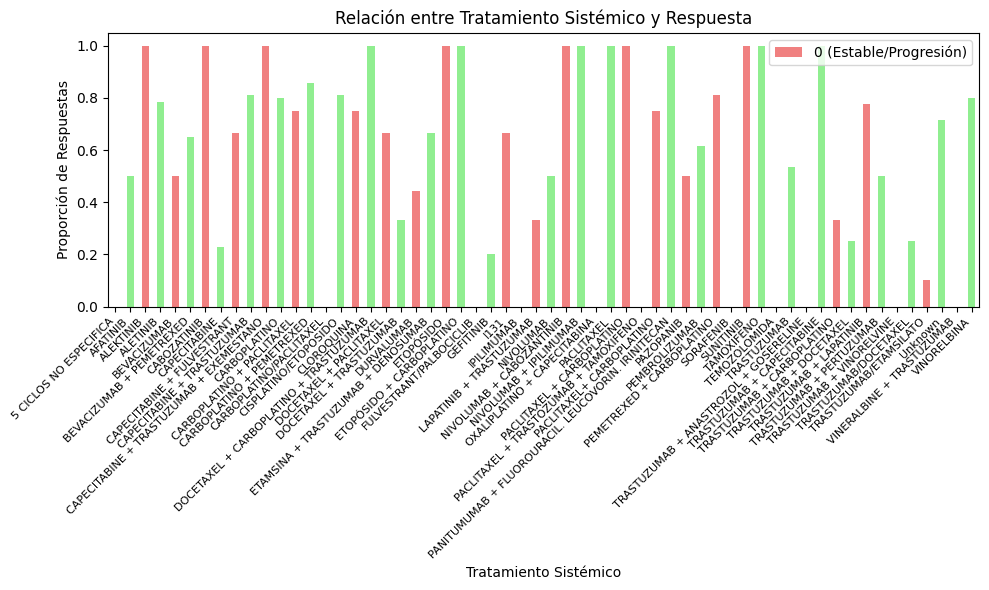

In [123]:
# Agrupar data por 'TRATAMIENTO SISTEMICO' y calcular la media de 'RESPUESTA_BINARIA'
grouped_data = df_cleaned.groupby('TRATAMIENTO SISTEMICO')['RESPUESTA_BINARIA'].mean()

# Realizar prueba chi-cuadrado
contingency_table = pd.crosstab(df_cleaned['TRATAMIENTO SISTEMICO'], df_cleaned['RESPUESTA_BINARIA'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)


print('\nResultados del Test Chi-cuadrado:')
print(f'Estadístico Chi2: {chi2:.4f}')
print(f'Valor p: {p_value:.4f}')
print('\nTabla de contingencia:')
print(contingency_table)

# Crear gráfico de barras apiladas
colors = ['lightcoral', 'lightgreen']  # Define los colores para las respuestas 0 y 1
grouped_data.plot(kind='bar', stacked=True, color=colors, figsize=(10, 6))

# Personalizar el gráfico
plt.title('Relación entre Tratamiento Sistémico y Respuesta')
plt.xlabel('Tratamiento Sistémico')
plt.ylabel('Proporción de Respuestas')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend(labels=['0 (Estable/Progresión)', '1 (Respuesta parcial/completa)'])
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Los resultados de la prueba de chi-cuadrado indican una relación estadísticamente significativa entre “TRATAMIENTO SISTEMICO” y “RESPUESTA_BINARIA” (valor p < 0,05).

Relación entre las columnas "TUMOR PRIMARIO" y "LOCALIZACIÓN"

In [124]:
print("Valores únicos en TUMOR PRIMARIO:")
print(df['TUMOR PRIMARIO'].unique())

Valores únicos en TUMOR PRIMARIO:
['CÁNCER DE MAMA' 'CÁNCER RENAL' 'CÁNCER DE PULMÓN' 'CÁNCER DE COLON'
 'CÁNCER DE ENDOMETRIO' 'CÁNCER CERVICOUTERINO' 'CÁNCER DE TIROIDES'
 'TUMOR NEUROECTODÉRMICO' 'MELANOMA' 'CÁNCER TESTICULAR'
 'CÁNCER DE OVARIO' 'CÁNCER DE PRÓSTATA' 'TUMOR NEUROENDOCRINO' nan
 'CÁNCER RENAL ' 'CÁNCER DE ESOFAGO']


In [125]:
df_cleaned['TUMOR PRIMARIO'] = df_cleaned['TUMOR PRIMARIO'].replace({'CÁNCER RENAL ': 'CÁNCER RENAL'}, regex=False)

In [126]:
print("Valores únicos en LOCALIZACIÓN:")
print(df['LOCALIZACIÓN'].unique())

Valores únicos en LOCALIZACIÓN:
['PARIETAL IZQ' 'FRONTAL DER' 'CEREBELO' 'FRONTAL IZQ' 'PARIETAL DER'
 'ÓRBITA IZQ' 'TENTORIAL' 'MESENCÉFALO' 'TEMPORAL IZQ' 'TEMPORAL DER'
 'OCCIPITO-PARIETAL DER' 'OCCIPITAL DER' 'OCCIPITAL IZQ' 'PARIETOOCIPITAL'
 'CEREBELO IZQ' 'CEREBELO DER' 'CEERBELO DER' 'ORBITARIA IZQ' 'PUENTE'
 'FRONTOPARIETAL DER' 'TÁLAMO DER' 'TÁLAMO IZQ' 'VERMIS CEREBELOSO'
 'PEDUNCULO SUP DER' 'ASTA POST VLI' 'INSULA' 'NUCLEOS DE LA BASE DER'
 'NUCLEO DE LA BASE IZQ' 'TALAMO DER' 'INSULAR' 'HOLOCRANEO'
 'ANGULO PONTOCEREBELOSO' 'CAUDADO DER' 'CAUDADO IZQ' 'VERMIS']


In [127]:
df_cleaned['LOCALIZACIÓN'] = df_cleaned['LOCALIZACIÓN'].replace({
    'PARIETAL IZQ': 'PARIETAL', 'PARIETAL DER': 'PARIETAL',
    'FRONTAL DER': 'FRONTAL', 'FRONTAL IZQ': 'FRONTAL',
    'CEREBELO IZQ': 'CEREBELO', 'CEREBELO DER': 'CEREBELO', 'CEERBELO DER': 'CEREBELO',
    'TEMPORAL IZQ': 'TEMPORAL', 'TEMPORAL DER': 'TEMPORAL',
    'INSULA': 'INSULAR', 'TÁLAMO DER': 'TÁLAMO', 'TÁLAMO IZQ': 'TÁLAMO',
    'CAUDADO DER': 'CAUDADO', 'CAUDADO IZQ': 'CAUDADO',
    'OCCIPITAL DER': 'OCCIPITAL', 'OCCIPITAL IZQ': 'OCCIPITAL',
    'OCCIPITO-PARIETAL DER': 'PARIETOOCIPITAL',
    'NUCLEOS DE LA BASE DER': 'NUCLEOS DE LA BASE',
    'NUCLEO DE LA BASE IZQ': 'NUCLEOS DE LA BASE',
    'TÁLAMO DER': 'TÁLAMO', 'TÁLAMO IZQ': 'TÁLAMO',
    'TALAMO DER': 'TÁLAMO', 'ORBITARIA IZQ': 'ÓRBITA IZQ',
    'VERMIS': 'VERMIS CEREBELOSO',

}, regex=False)


Resultados del Test Chi-cuadrado:
Estadístico Chi2: 477.4825
Valor p: 0.0000

Tabla de contingencia:
LOCALIZACIÓN            ANGULO PONTOCEREBELOSO  ASTA POST VLI  CAUDADO  \
TUMOR PRIMARIO                                                           
CÁNCER CERVICOUTERINO                        0              0        0   
CÁNCER DE COLON                              0              0        0   
CÁNCER DE ENDOMETRIO                         0              0        0   
CÁNCER DE ESOFAGO                            0              0        0   
CÁNCER DE MAMA                               0              0        0   
CÁNCER DE OVARIO                             0              0        0   
CÁNCER DE PRÓSTATA                           0              0        0   
CÁNCER DE PULMÓN                             0              0        2   
CÁNCER DE TIROIDES                           0              0        0   
CÁNCER RENAL                                 0              1        0   
CÁNCER TES

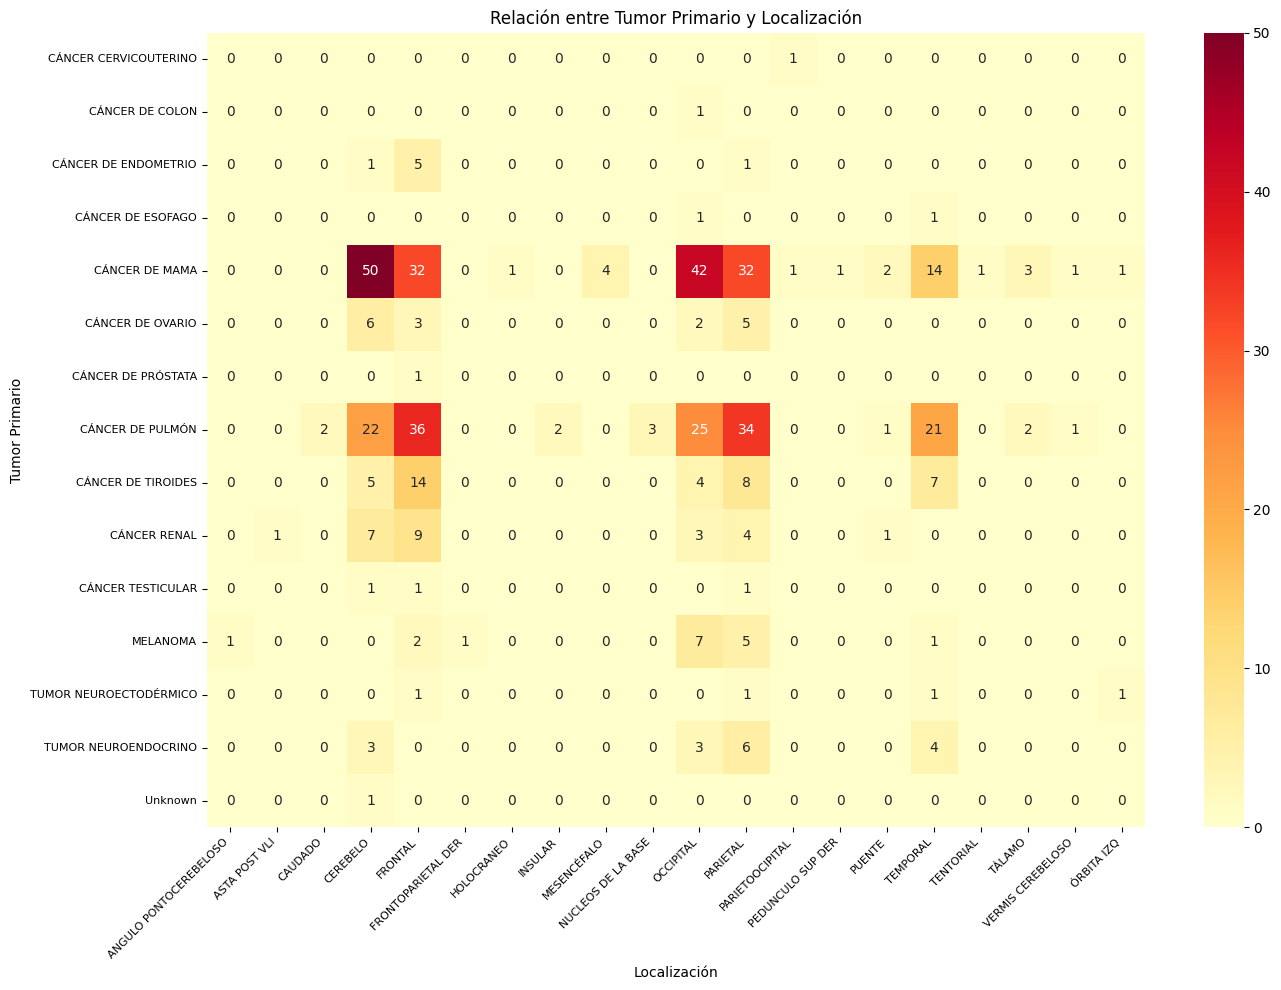

In [128]:
# Crear tabla de contingencia
contingency_table = pd.crosstab(df_cleaned['TUMOR PRIMARIO'], df_cleaned['LOCALIZACIÓN'])

# Realizar prueba chi-cuadrado
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print('\nResultados del Test Chi-cuadrado:')
print(f'Estadístico Chi2: {chi2:.4f}')
print(f'Valor p: {p_value:.4f}')
print('\nTabla de contingencia:')
print(contingency_table)

# Crear un heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(contingency_table, annot=True, cmap='YlOrRd', fmt='d')
plt.title('Relación entre Tumor Primario y Localización')
plt.xlabel('Localización')
plt.ylabel('Tumor Primario')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

El estadístico chi-cuadrado obtenido fue de 1242.1673 con un valor p < 0.05. Esto indica una relación estadísticamente significativa entre el tipo de tumor primario y la localización de la metástasis. Es decir, el tipo de tumor primario influye en la localización de la metástasis.

Encontramos principalmente una relación de tumor primario en mama con la localización en lóbulo occipital, lóbulo parietal, lóbulo frontal y cerebelo.
Además, otra relación importante es entre tumor primario en pulmón y localización en lóbulo frontal (con ayor incidencia en lóbulo frontal derecho respecto al izquierdo), lóbulo parietal, lóbulo occipital, lóbulo temporal y cerebelo.

In [129]:
print("Valores únicos en SRS:")
print(df['SRS'].unique())

Valores únicos en SRS:
['DU' 'HIPO FX' nan 'DU ' 'HIPOFX' 'CONV']


In [130]:
df_cleaned['SRS'] = df_cleaned['SRS'].replace({
    'DU ': 'DU (dosis única)',
    'DU': 'DU (dosis única)',
    'HIPOFX': 'HIPO FX',
    'PROGRESION': 'PROGRESIÓN'
}, regex=False)

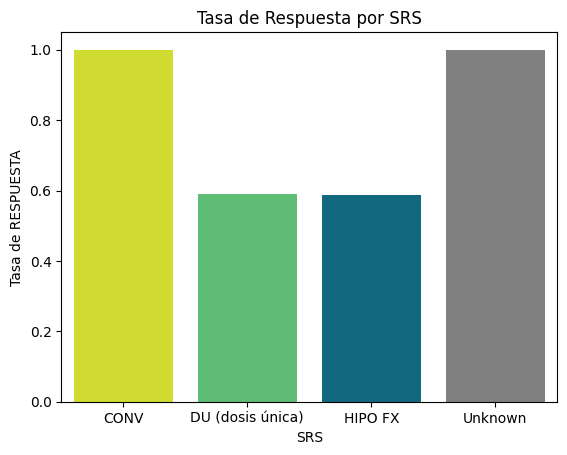

Resultado del test Chi-squared:
Chi2: 1.386982947545065
p-value: 0.708588817620664
Grados de libertad: 3
Frecuencias esperadas:
[[  0.40772532   0.59227468]
 [149.63519313 217.36480687]
 [ 39.54935622  57.45064378]
 [  0.40772532   0.59227468]]


In [131]:
# Agrupar datos por 'SRS' y calcular la media de 'RESPUESTA_BINARIA'
grouped_data = df_cleaned.groupby('SRS')['RESPUESTA_BINARIA'].mean()

# Realizar prueba de chi-cuadrado para evaluar la independencia
contingency_table = pd.crosstab(df_cleaned['SRS'], df_cleaned['RESPUESTA_BINARIA'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Lista de colores personalizada (uno para cada barra)
colors1 = ['#eaf816', '#50cd6d', '#007491', '#808080']

# Visualizar gráfico
sns.barplot(x=grouped_data.index, y=grouped_data.values, palette=colors1)

plt.title('Tasa de Respuesta por SRS')
plt.xlabel('SRS')
plt.ylabel('Tasa de RESPUESTA')
plt.show()

# Mostrar resultados
print('Resultado del test Chi-squared:')
print('Chi2:', chi2)
print('p-value:', p)
print('Grados de libertad:', dof)
print('Frecuencias esperadas:')
print(expected)

Dado que el valor p de la prueba de chi-cuadrado para 'SRS' y 'RESPUESTA_BINARIA' es mayor que 0.05, indica que no hay una relación estadísticamente significativa entre estas dos variables.

In [151]:
print("Valores únicos en SUBTIPO HISTOLOGICO:")
print(df['SUBTIPO HISTOLOGICO'].unique())

Valores únicos en SUBTIPO HISTOLOGICO:
['CARCINOMA DUCTAL INFILTRANTE' 'CARCINOMA DE CÉLULAS CLARAS'
 'ADENOCARCINOMA ACINAR' 'CELULAS CLARAS'
 'ADENOCARCINOMA CÉLULAS NO PEQUEÑAS' nan 'CARCINOMA ANAPLÁSICO'
 'CARCINOMA UROTELIAL' 'ADENOCARCINOMA' 'CARCINOMA PAPILAR'
 'CARCINOMA EPIDERMOIDE' 'CARCINOMA DE CELULAS CLARAS'
 '80% CORIOCARCINOMA. 15%SV' 'CARCINOMA'
 'ADENOCARCINOMA DE CÉLULAS NO PEQUEÑAS' 'ADENOCARCINOMA '
 'ADENOCARCINOMA PAPILAR' 'ADENOCARCINOMA DE CÉLULAS EN ANILLO DE SELLO'
 'CARCINOMA EPITELIAL' 'CARCINOMA DUCTAL INFILTRANTE '
 'CARCINOMA DE CÉLULAS PEQUEÑAS' 'CARCINOMA POCO DIFERENCIADO']


In [152]:
df_cleaned['SUBTIPO HISTOLOGICO'] = df_cleaned['SUBTIPO HISTOLOGICO'].replace({
    'CARCINOMA DE CELULAS CLARAS': 'CARCINOMA DE CÉLULAS CLARAS',
    'CELULAS CLARAS': 'CARCINOMA DE CÉLULAS CLARAS',
    'DENOCARCINOMA DE CÉLULAS NO PEQUEÑAS': 'ADENOCARCINOMA CÉLULAS NO PEQUEÑAS',
    'ADENOCARCINOMA ': 'ADENOCARCINOMA',
}, regex=False)

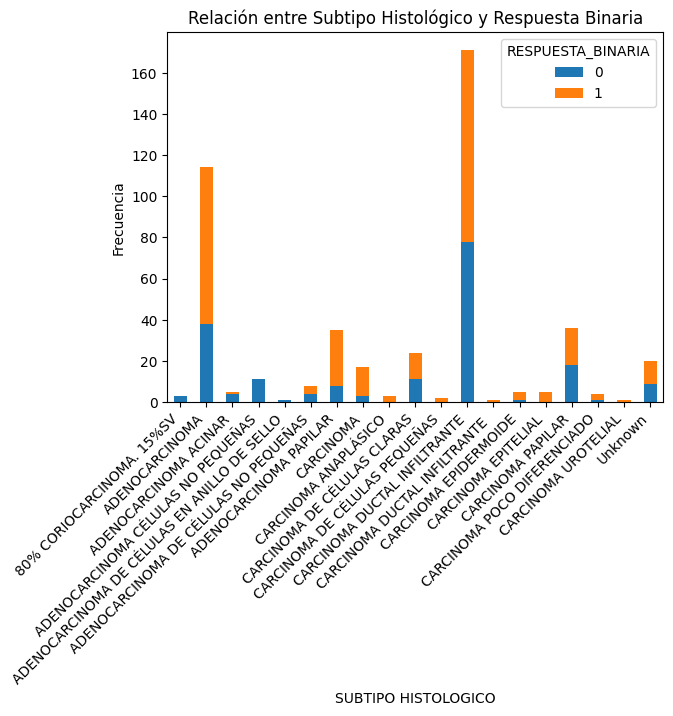

Resultado del test Chi-squared:
Chi2: 49.18497571299587
p-value: 0.00010015291992928528
Grados de libertad: 18
Frecuencias esperadas:
[[  1.22317597   1.77682403]
 [ 46.4806867   67.5193133 ]
 [  2.03862661   2.96137339]
 [  4.48497854   6.51502146]
 [  0.40772532   0.59227468]
 [  3.26180258   4.73819742]
 [ 14.27038627  20.72961373]
 [  6.93133047  10.06866953]
 [  1.22317597   1.77682403]
 [  9.78540773  14.21459227]
 [  0.81545064   1.18454936]
 [ 69.72103004 101.27896996]
 [  0.40772532   0.59227468]
 [  2.03862661   2.96137339]
 [  2.03862661   2.96137339]
 [ 14.67811159  21.32188841]
 [  1.63090129   2.36909871]
 [  0.40772532   0.59227468]
 [  8.15450644  11.84549356]]


In [158]:
# Agrupa los datos por 'SUBTIPO HISTOLOGICO' y calcula la media de 'RESPUESTA_BINARIA'
grouped_data = df_cleaned.groupby('SUBTIPO HISTOLOGICO')['RESPUESTA_BINARIA'].mean()

# Realiza la prueba de chi-cuadrado para evaluar la independencia
contingency_table = pd.crosstab(df_cleaned['SUBTIPO HISTOLOGICO'], df_cleaned['RESPUESTA_BINARIA'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Visualiza los resultados
# Crear tabla de contingencia
contingency_table = pd.crosstab(df_cleaned['SUBTIPO HISTOLOGICO'], df_cleaned['RESPUESTA_BINARIA'])

# Graficar barras apiladas
contingency_table.plot(kind='bar', stacked=True)
plt.title('Relación entre Subtipo Histológico y Respuesta Binaria')
plt.xlabel('SUBTIPO HISTOLOGICO')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.show()

# Muestra los resultados de la prueba de chi-cuadrado
print('Resultado del test Chi-squared:')
print('Chi2:', chi2)
print('p-value:', p)
print('Grados de libertad:', dof)
print('Frecuencias esperadas:')
print(expected)

Los resultados de la prueba de chi-cuadrado indican una relación estadísticamente significativa entre el subtipo histológico y la respuesta binaria (χ² = 49.18, p < 0.05). Esto significa que el subtipo histológico del tumor tiene un impacto en la probabilidad de obtener una respuesta favorable (RESPUESTA_BINARIA = 1) al tratamiento.
En otras palabras, diferentes subtipos histológicos tienen diferentes tasas de respuesta al tratamiento.